<a href="https://colab.research.google.com/github/rihannh/ML-DeepL-Assignment-1/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

In [3]:
try:
  df = pd.read_csv('/content/Combined Data.csv')
except FileNotFoundError:
  print("Error: Pastikan file ada di direktori yang sama.")
  exit()

In [4]:
print("Info Dataset:")
df.info()

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
print("Baris Pertama:")
print(df.head())

Baris Pertama:
   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [6]:
print(f"\nJumlah nilai null sebelum dihapus: {df.isnull().sum().sum()}")
df.dropna(inplace=True)
print(f"Jumlah nilai null setelah dihapus: {df.isnull().sum().sum()}")


Jumlah nilai null sebelum dihapus: 362
Jumlah nilai null setelah dihapus: 0


In [7]:
print("\nDistribusi Label Sentimen:")
print(df['status'].value_counts())


Distribusi Label Sentimen:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


<ipython-input-8-1012585552>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='status', data=df, palette='viridis')


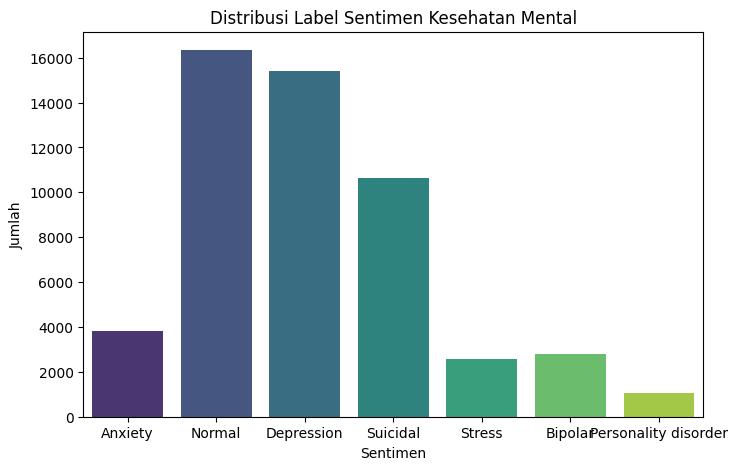

In [8]:
plt.figure(figsize=(8, 5))
sns.countplot(x='status', data=df, palette='viridis')
plt.title('Distribusi Label Sentimen Kesehatan Mental')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [9]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng')
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')

print("Semua paket NLTK sudah siap.")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Semua paket NLTK sudah siap.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    else: return wordnet.NOUN

def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    if not tokens: return ""
    pos_tags = pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    return ' '.join(lemmatized_tokens)


In [11]:
df['cleaned_text'] = df['statement'].apply(clean_and_lemmatize)

In [12]:
print("\nContoh Hasil Cleaning:")
df[['statement', 'cleaned_text']].head()


Contoh Hasil Cleaning:


,statement,cleaned_text
0,oh my gosh,oh gosh
1,"trouble sleeping, confused mind, restless hear...",trouble sleep confuse mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",wrong back dear forward doubt stay restless re...
3,I've shifted my focus to something else but I'...,ive shift focus something else im still worry
4,"I'm restless and restless, it's been a month n...",im restless restless month boy mean


In [13]:
X = df['cleaned_text']
y = pd.get_dummies(df['status'], dtype=int).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Bentuk data latih (X_train): {X_train.shape}")
print(f"Bentuk data uji (X_test): {X_test.shape}")
print(f"Bentuk label latih (y_train): {y_train.shape}")
print(f"Bentuk label uji (y_test): {y_test.shape}")

Bentuk data latih (X_train): (42144,)
Bentuk data uji (X_test): (10537,)
Bentuk label latih (y_train): (42144, 7)
Bentuk label uji (y_test): (10537, 7)


In [14]:
print("Label Sentimen Setelah One-Hot Encoding:")
print(y_train[:5])

Label Sentimen Setelah One-Hot Encoding:
[[0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]]


In [15]:
vocab_size = 10000
max_len = 100
embedding_dim = 128

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"Contoh data setelah padding:\n{X_train_pad[0]}")

Contoh data setelah padding:
[   2 1686   21  761   14  188    2 1165 3791    7   44  196  186  450
 2845  730   40   21  530  763  213    5  102  761    2 1774 2047   91
  292  788  166  473 8744  292 2366    1  292  445  940 1403   91  292
 2047  640   49   83  166 1184  445  117  940    1  863  433 9454  940
  627  571 2252 3855  167  166  571 2252  119  571  166  650 1185  167
  571  166 2252  166    1  352 1136  314    1 1137  453 1300  213  155
 1300  253  591 2452  999   14  159  242  170   43  761 4979  471 1271
 1240    1]


In [16]:
vocab_size = 10000
max_len = 100
embedding_dim = 128

model = Sequential([
  Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len),
  Bidirectional(LSTM(64, return_sequences=True)),
  Dropout(0.3),
  Bidirectional(LSTM(32)),
  Dropout(0.3),
  Dense(64, activation='relu'),
  Dense(y_train.shape[1], activation='softmax')
])

model.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [17]:
num_epochs = 20
batch_size = 64

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_mental_health_model.keras', save_best_only=True, monitor='val_accuracy')
]

history = model.fit(
    X_train_pad, y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_split=0.15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.5384 - loss: 1.1922 - val_accuracy: 0.6693 - val_loss: 0.7931
Epoch 2/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - accuracy: 0.7058 - loss: 0.7213 - val_accuracy: 0.7422 - val_loss: 0.6732
Epoch 3/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7947 - loss: 0.5418 - val_accuracy: 0.7483 - val_loss: 0.6719
Epoch 4/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8319 - loss: 0.4451 - val_accuracy: 0.7412 - val_loss: 0.6952
Epoch 5/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 21s 22ms/step - accuracy: 0.8593 - loss: 0.3783 - val_accuracy: 0.7580 - val_loss: 0.6988
Epoch 6/20
560/560 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - accuracy: 0.8831 - loss: 0.3213 - val_accuracy: 0.7558 - val_loss: 0.7434


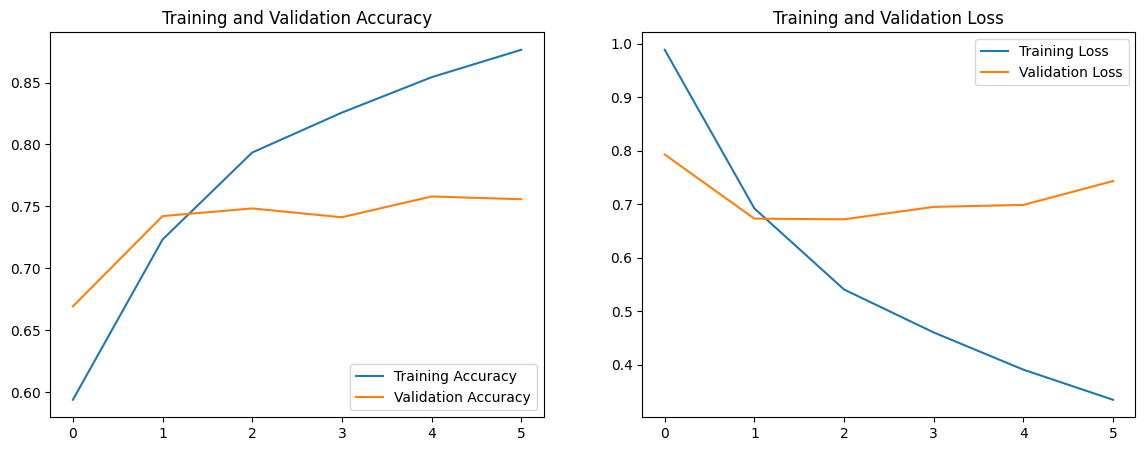

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mengevaluasi model pada data uji...
Test Loss: 0.6728
Test Accuracy: 0.7429
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Laporan Klasifikasi:
                      precision    recall  f1-score   support

             Anxiety       0.80      0.78      0.79       768
             Bipolar       0.79      0.77      0.78       556
          Depression       0.72      0.65      0.68      3081
              Normal       0.92      0.90      0.91      3269
Personality disorder       0.43      0.23      0.30       215
              Stress       0.42      0.63      0.50       517
            Suicidal       0.62      0.70      0.66      2131

            accuracy                           0.74     10537
           macro avg       0.67      0.67      0.66     10537
        weighted avg       0.75      0.74      0.74     10537



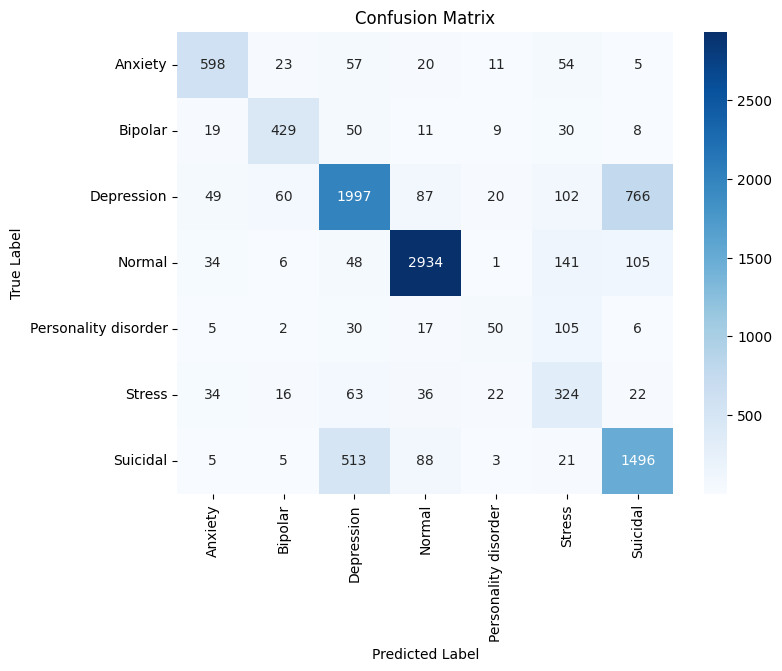

In [20]:
print("Evaluate Model")
results = model.evaluate(X_test_pad, y_test, verbose=0)
print(f"Test Loss: {results[0]:.4f}")
print(f"Test Accuracy: {results[1]:.4f}")

y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
class_labels = list(pd.get_dummies(df['status']).columns)

print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred, target_names=class_labels))

cm = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()